<div align="center">

# <span style="color: #3498db;">Genetic & MiniMax</span>

**<span style="color:rgb(247, 169, 0);">Artin Tavasoli</span> - <span style="color:rgb(143, 95, 195);">810102543</span>**

</div>


## 🧬 Part 1: Approximating Fourier Coefficients Using Genetic Algorithm

**Objective:**  
Estimate the Fourier series coefficients of an unknown function using a genetic algorithm.

---



In [4]:
import matplotlib.pyplot as plt

# <span style="color: #3498db;">Genetic Algorithm</span>

In [5]:
import random
import itertools
import numpy as np
import sys
sys.setrecursionlimit(3000)


In [6]:
# algorithm parameters
numCoeffs = 41
populationSize = 100
generations = 500
mutationRate = 0.1
functionRange = (-np.pi, np.pi)
sampleCount = 100
coeff_range = (-2, 2)
crossover_rate =  0.8
tournament_var = 5
crossover_type = 0
fitness_type = 0 
selection_type = 0
number_of_points_crossover = 3
random.seed(543)

In [7]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

In [ ]:
def gen_tsamples_and_fsamples(function_name):
    tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
    fSamples = getTargetFunction(function_name)(tSamples)
    return tSamples, fSamples

In [10]:
def create_first_gen_chromosome(fSamples):
    coeffs = np.random.uniform(coeff_range[0], coeff_range[1], size=numCoeffs)
    first_coeff = coeffs[0]
    cos_coeffs = coeffs[1:(numCoeffs + 1) // 2]
    sin_coeffs = coeffs[(numCoeffs + 1) // 2:]
    # valid_boarder = check_fboarder(first_coeff, cos_coeffs, sin_coeffs, maxf, minf, is_f_periodic)
    # if not valid_boarder:
    #     return create_first_gen_chromosome(fSamples, is_f_periodic)
    return [first_coeff, cos_coeffs, sin_coeffs]

In [11]:
def create_first_gen_chromosomes(fSamples):
    chromosomes = []
    for _ in range(populationSize):
        chromosomes.append(create_first_gen_chromosome(fSamples))
    return chromosomes

In [12]:
def calculate_chromosome_fvals(chromosome, tSamples):
    number_of_terms = (numCoeffs - 1) // 2
    index_arr = np.arange(1, number_of_terms + 1)
    cos_terms = np.cos(np.outer(tSamples, index_arr))
    sin_terms = np.sin(np.outer(tSamples, index_arr))
    a0 = chromosome[0] / 2
    cosine_coeffs = np.array(chromosome[1])
    sine_coeffs = np.array(chromosome[2])
    f_vals = a0 + cos_terms @ cosine_coeffs + sin_terms @ sine_coeffs
    return f_vals

In [13]:
def calculate_chromosomes_fvals(chromosomes, tSamples):
    f_values_for_chromosomes = []
    for chromosome in chromosomes:
        f_vals = calculate_chromosome_fvals(chromosome, tSamples)
        f_values_for_chromosomes.append(f_vals.tolist())
    return f_values_for_chromosomes

In [14]:
def rank_chromosomes_by_rmse(chromosomes, tSamples, fSamples):
    f_values = np.array(calculate_chromosomes_fvals(chromosomes, tSamples))

    fitness_vals = np.sqrt(np.mean((f_values - fSamples) ** 2, axis=1))

    sorted_indexes = np.argsort(fitness_vals)

    sorted_chromosomes = [chromosomes[i] for i in sorted_indexes]
    
    fitness_vals = fitness_vals[sorted_indexes]
    
    return fitness_vals, sorted_chromosomes


In [15]:
def rank_chromosomes_by_mae(chromosomes, tSamples, fSamples):
    f_values = np.array(calculate_chromosomes_fvals(chromosomes, tSamples))

    fitness_vals = np.mean(np.abs(f_values - fSamples), axis=1)

    sorted_indexes = np.argsort(fitness_vals)

    sorted_chromosomes = [chromosomes[i] for i in sorted_indexes]
    
    fitness_vals = fitness_vals[sorted_indexes]
    
    return fitness_vals, sorted_chromosomes

In [16]:
def rank_chromosomes_by_cnt_close_points(chromosomes, tSamples, fSamples, error_interval):
    f_values = np.array(calculate_chromosomes_fvals(chromosomes, tSamples))

    close_points = np.abs(f_values - fSamples) <= error_interval

    fitness_vals = np.sum(close_points, axis=1)

    sorted_indexes = np.argsort(-fitness_vals)

    sorted_chromosomes = [chromosomes[i] for i in sorted_indexes]
    
    fitness_vals = fitness_vals[sorted_indexes]

    return fitness_vals, sorted_chromosomes


In [17]:
def split_replace(arr1, arr2):
    points = np.sort(np.random.choice(np.arange(1, len(arr1)), size=number_of_points_crossover, replace=False))
    points = np.hstack(([0], points, [len(arr1)]))
    child1 = []
    child2 = []
    for i in range(len(points) - 1):
        start, end = points[i], points[i + 1]
        if i % 2 == 0:
            child1.append(arr1[start:end])
            child2.append(arr2[start:end])
        else:
            child1.append(arr2[start:end])
            child2.append(arr1[start:end])
    return np.hstack(child1), np.hstack(child2)

In [18]:
def cross_over0(chromosome1, chromosome2):
    if np.random.rand() < crossover_rate:
        return [chromosome1, chromosome2]
     
    chrom1_a0, chrom1_cos, chrom1_sin = chromosome1
    chrom2_a0, chrom2_cos, chrom2_sin = chromosome2
    if np.random.rand() < 0.5:
        a0_child1 = chrom1_a0
        a0_child2 = chrom2_a0
    else:
        a0_child1 = chrom2_a0
        a0_child2 = chrom1_a0
    cos_child1, cos_child2 = split_replace(chrom1_cos, chrom2_cos)
    sin_child1, sin_child2 = split_replace(chrom1_sin, chrom2_sin)
    return [[a0_child1, cos_child1, sin_child1], [a0_child2, cos_child2, sin_child2]]

In [19]:
def cross_over1(chromosome1, chromosome2):
    if np.random.rand() < crossover_rate:
        return [chromosome1, chromosome2]
    
    chrom1_a0, chrom1_cos, chrom1_sin = chromosome1
    chrom2_a0, chrom2_cos, chrom2_sin = chromosome2
    if np.random.rand() < 0.5:
        a0_child1 = chrom1_a0
        a0_child2 = chrom2_a0
    else:
        a0_child1 = chrom2_a0
        a0_child2 = chrom1_a0

    rand_point = random.randint(1, len(chrom1_cos) - 1)

    cos_child1 = np.hstack([chrom1_cos[:rand_point], chrom2_cos[rand_point:]])
    cos_child2 = np.hstack([chrom2_cos[:rand_point], chrom1_cos[rand_point:]])

    sin_child1 = np.hstack([chrom1_sin[:rand_point], chrom2_sin[rand_point:]])
    sin_child2 = np.hstack([chrom2_sin[:rand_point], chrom1_sin[rand_point:]])
    return [[a0_child1, cos_child1, sin_child1], [a0_child2, cos_child2, sin_child2]]

In [20]:
def cross_over2(chromosome1, chromosome2):
    if np.random.rand() < crossover_rate:
        return [chromosome1, chromosome2]
    
    chrom1_a0, chrom1_cos, chrom1_sin = chromosome1
    chrom2_a0, chrom2_cos, chrom2_sin = chromosome2
    if np.random.rand() < 0.5:
        a0_child1 = chrom1_a0
        a0_child2 = chrom2_a0
    else:
        a0_child1 = chrom2_a0
        a0_child2 = chrom1_a0
    
    cos_mask = np.random.choice([0, 1], size=len(chrom1_cos))
    sin_mask = np.random.choice([0, 1], size=len(chrom1_sin))
    
    new_cos_child1 = np.where(cos_mask, chrom1_cos, chrom2_cos)
    new_sin_child1 = np.where(sin_mask, chrom1_sin, chrom2_sin)
    
    new_cos_child2 = np.where(cos_mask, chrom2_cos, chrom1_cos)
    new_sin_child2 = np.where(sin_mask, chrom2_sin, chrom1_sin)
    
    return [[a0_child1, new_cos_child1, new_sin_child1], [a0_child2, new_cos_child2, new_sin_child2]]

In [21]:
def mutation(chromosome, mutation_val):
    a0, cos_coeffs, sin_coeffs = chromosome
    if np.random.rand() < mutationRate:
        a0 += np.random.normal(0, mutation_val)
    n = len(cos_coeffs)
    cos_coeffs = cos_coeffs + np.random.normal(0, mutation_val, size=n) * (np.random.rand(n) < mutationRate)
    sin_coeffs = sin_coeffs + np.random.normal(0, mutation_val, size=n) * (np.random.rand(n) < mutationRate)
    return [a0, cos_coeffs, sin_coeffs]

In [22]:
def tournament_selection(chromosomes, fitness_vals):
    indixes = np.random.choice(len(chromosomes), size=tournament_var, replace=False)
    best_index = indixes[np.argmin(fitness_vals[indixes])]
    return chromosomes[best_index]


In [23]:
def rank_based_roulette_wheel(chromosomes):
    ranks = np.arange(1, len(chromosomes) + 1)
    inverse_ranks = 1 / ranks
    probabilities = inverse_ranks / np.sum(inverse_ranks)
    selected_index = np.random.choice(len(chromosomes), p=probabilities)
    return chromosomes[selected_index]

In [24]:
def ga_cycle(chromosomes, best_chroms_cnt, cross_over_cnt, tSamples, fSamples):
    next_generation = []
    if fitness_type == 0:
        fitness_vals, chromosomes = rank_chromosomes_by_rmse(chromosomes, tSamples, fSamples)
    elif fitness_type == 1:
        fitness_vals, chromosomes = rank_chromosomes_by_mae(chromosomes, tSamples, fSamples)
    else:
        fitness_vals, chromosomes = rank_chromosomes_by_cnt_close_points(chromosomes, tSamples, fSamples, 0.1)
        
    for _ in range(cross_over_cnt):
        if selection_type == 0:
            parent1 = tournament_selection(chromosomes, fitness_vals)
            parent2 = tournament_selection(chromosomes, fitness_vals)
        else:
            parent1 = rank_based_roulette_wheel(chromosomes)
            parent2 = rank_based_roulette_wheel(chromosomes)
        if crossover_type == 0:
            child1, child2 = cross_over0(parent1, parent2)
        elif crossover_type == 1:
            child1, child2 = cross_over1(parent1, parent2)
        else:
            child1, child2 = cross_over2(parent1, parent2)
        next_generation.append(child1)
        next_generation.append(child2)
    
    for _ in range(best_chroms_cnt):
        if selection_type == 0:
            best = tournament_selection(chromosomes, fitness_vals)
        else:
            best = rank_based_roulette_wheel(chromosomes)
        next_generation.append(best)

    for i in range(len(next_generation)):
        next_generation[i] = mutation(next_generation[i], np.max(fSamples) / 10)

    return next_generation

In [25]:
def calc_final_f_vals(tSamples, fSamples):
    chromosomes = create_first_gen_chromosomes(fSamples)
    best_chroms_cnt = 8
    cross_over_cnt = populationSize - best_chroms_cnt

    for _ in range(generations):
        chromosomes = ga_cycle(chromosomes, best_chroms_cnt, cross_over_cnt, tSamples, fSamples)
    f_vals = calculate_chromosome_fvals(chromosomes[0], tSamples)
    return f_vals


CROSS_OVER_TYPES

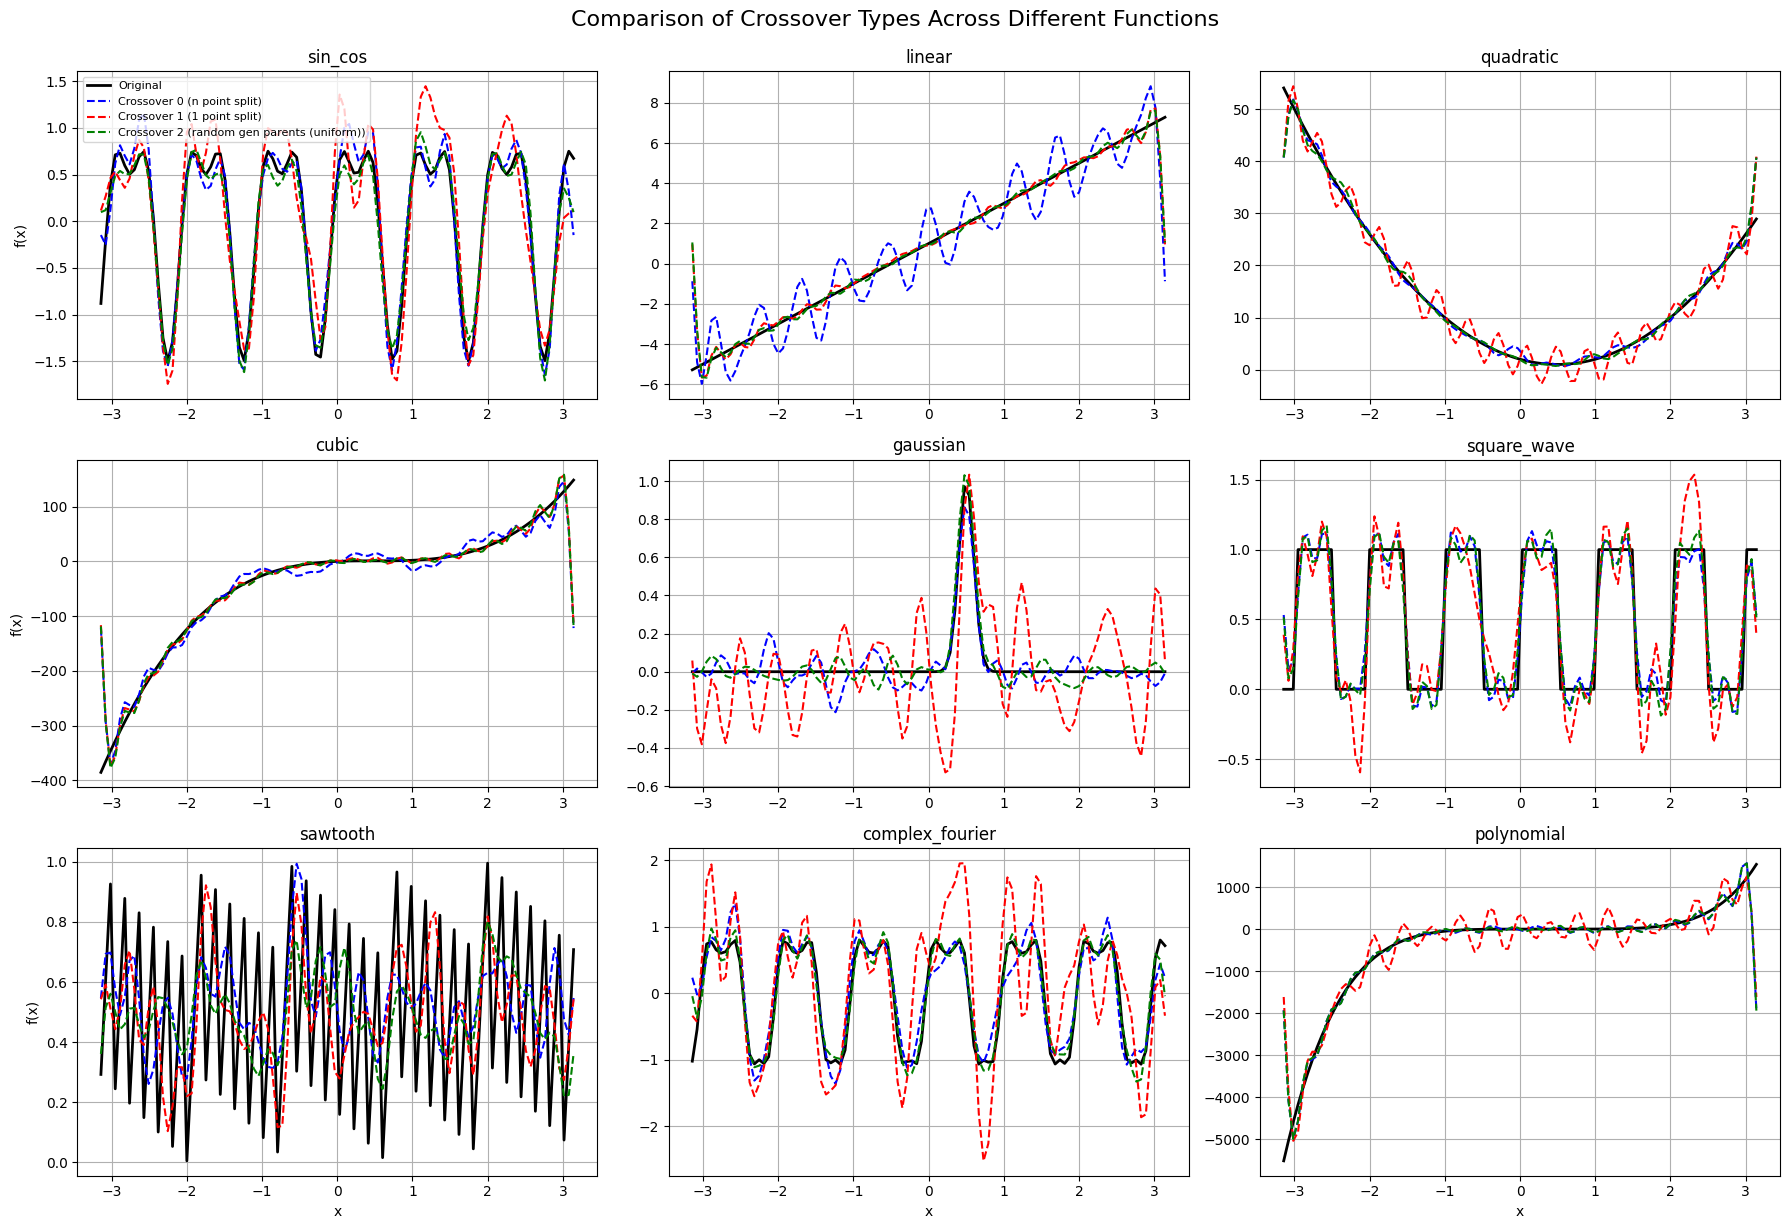

In [26]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    crossover_type = 0
    f_vals = calc_final_f_vals(tSamples, fSamples)

    crossover_type = 1
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    crossover_type = 2
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='Crossover 0 (n point split)', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='Crossover 1 (1 point split)', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='Crossover 2 (random gen parents (uniform))', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Crossover Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Fitness Types

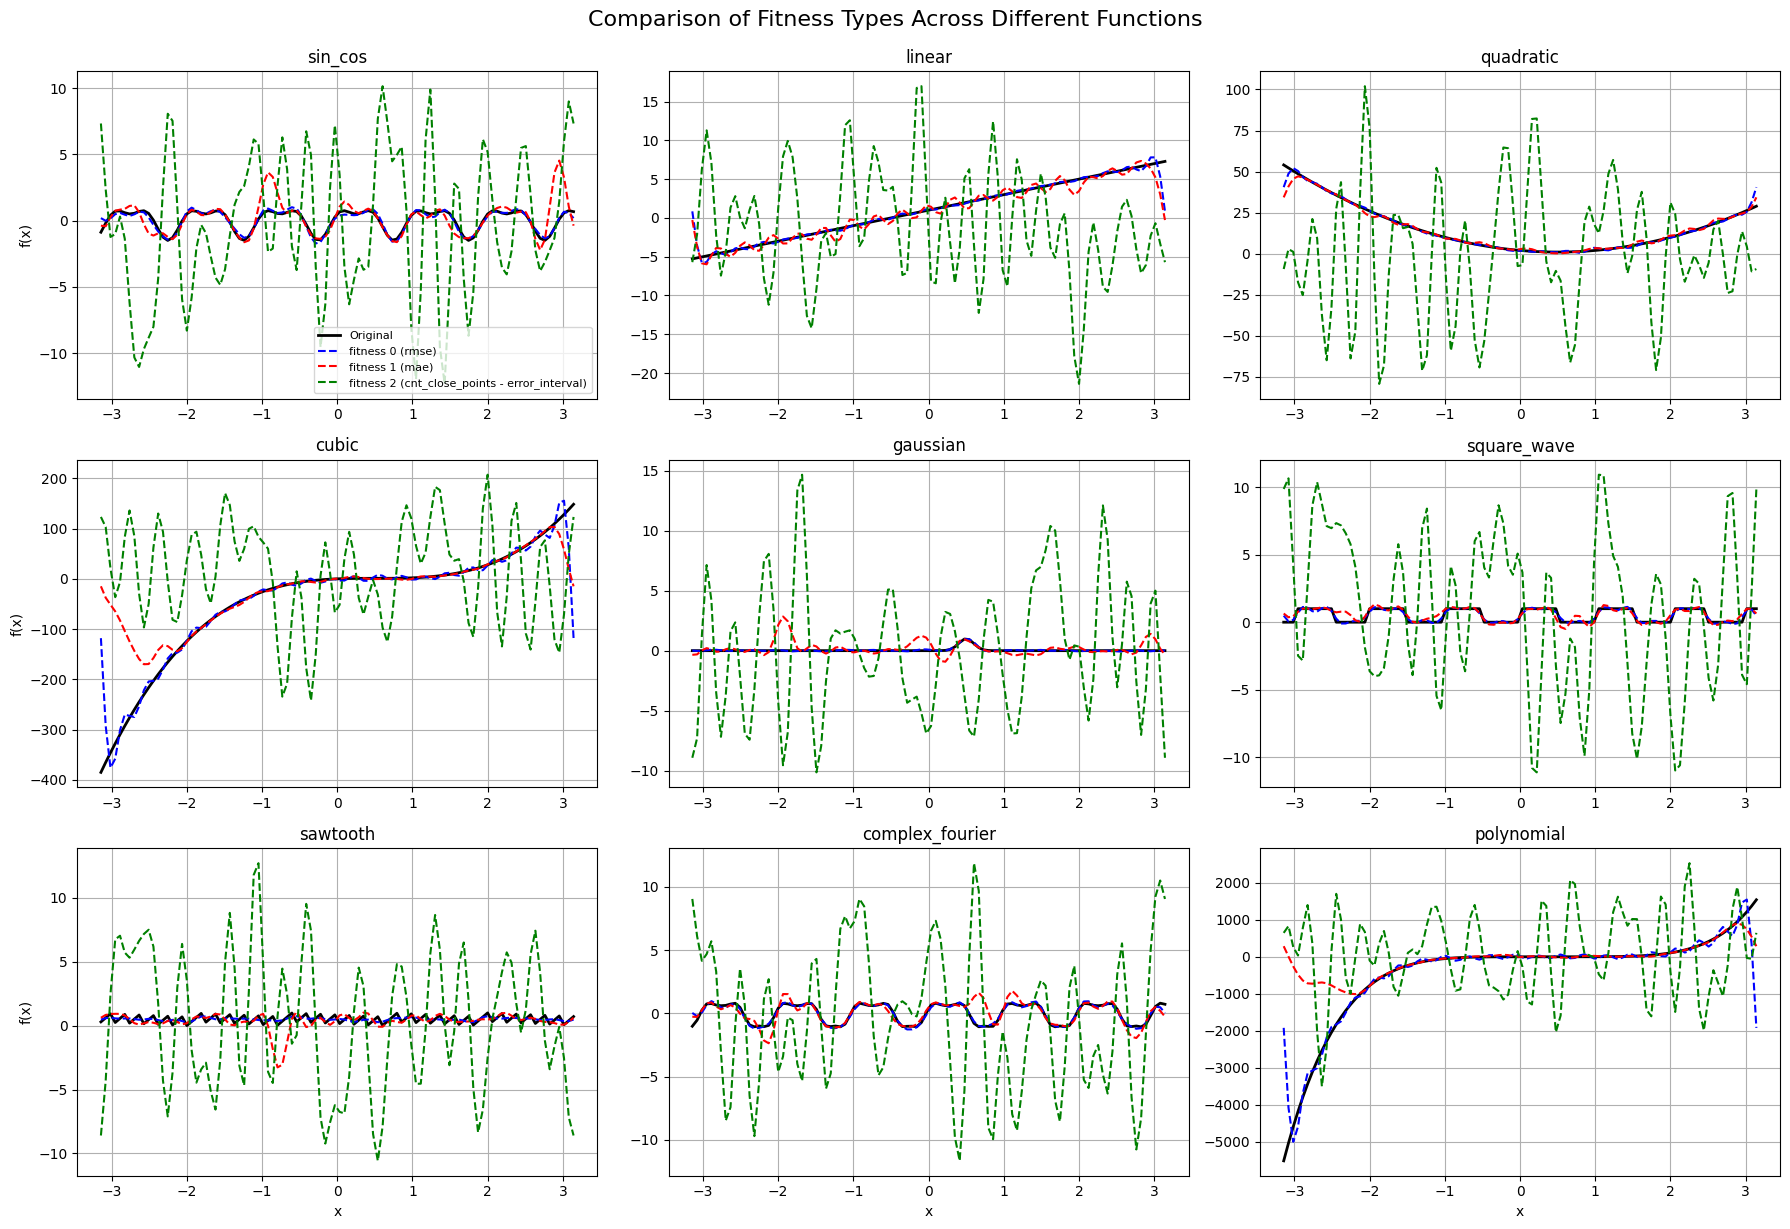

In [27]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    fitness_type = 0
    f_vals = calc_final_f_vals(tSamples, fSamples)

    fitness_type = 1
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    fitness_type = 2
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='fitness 0 (rmse)', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='fitness 1 (mae)', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='fitness 2 (cnt_close_points - error_interval)', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Fitness Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Selection Type

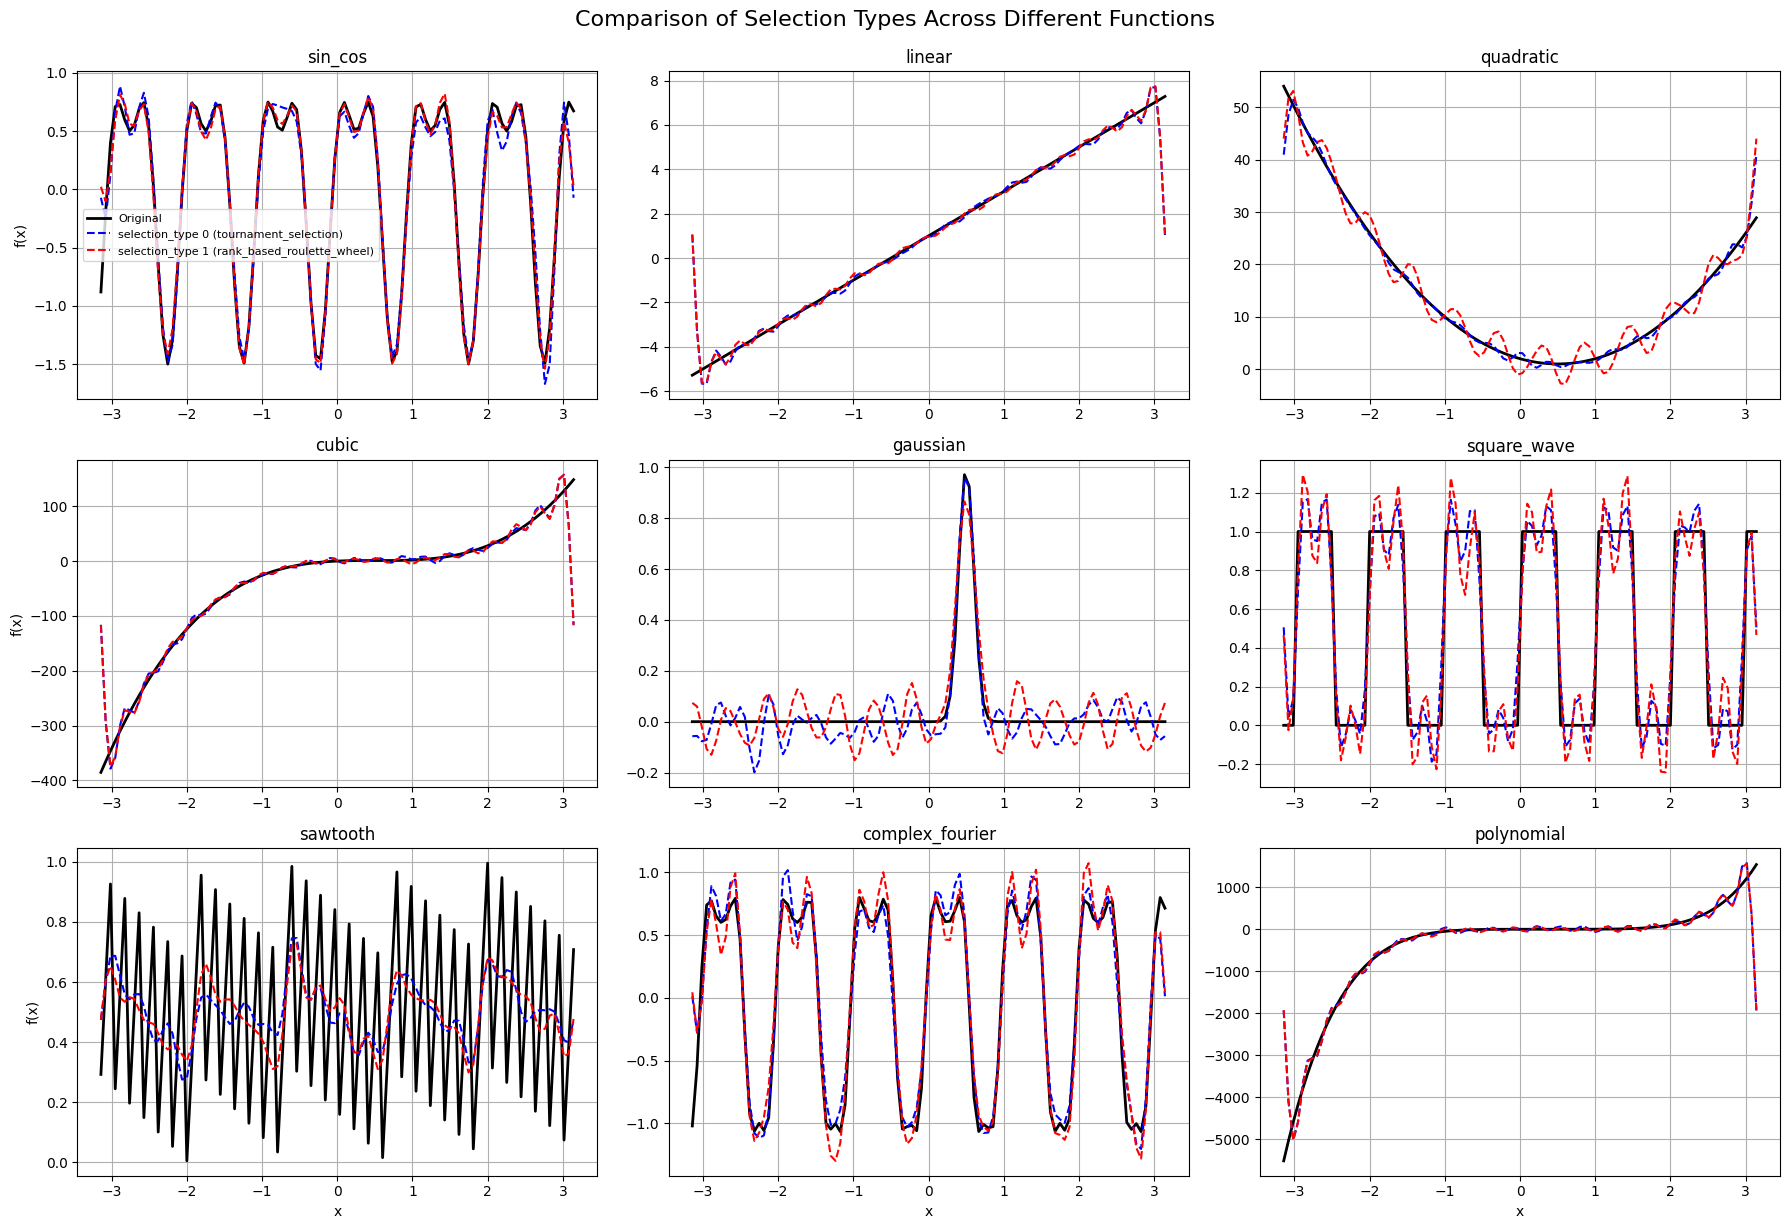

In [28]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    selection_type = 0
    f_vals = calc_final_f_vals(tSamples, fSamples)

    selection_type = 1
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='selection_type 0 (tournament_selection)', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='selection_type 1 (rank_based_roulette_wheel)', linestyle='--', color='red')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Selection Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Population size

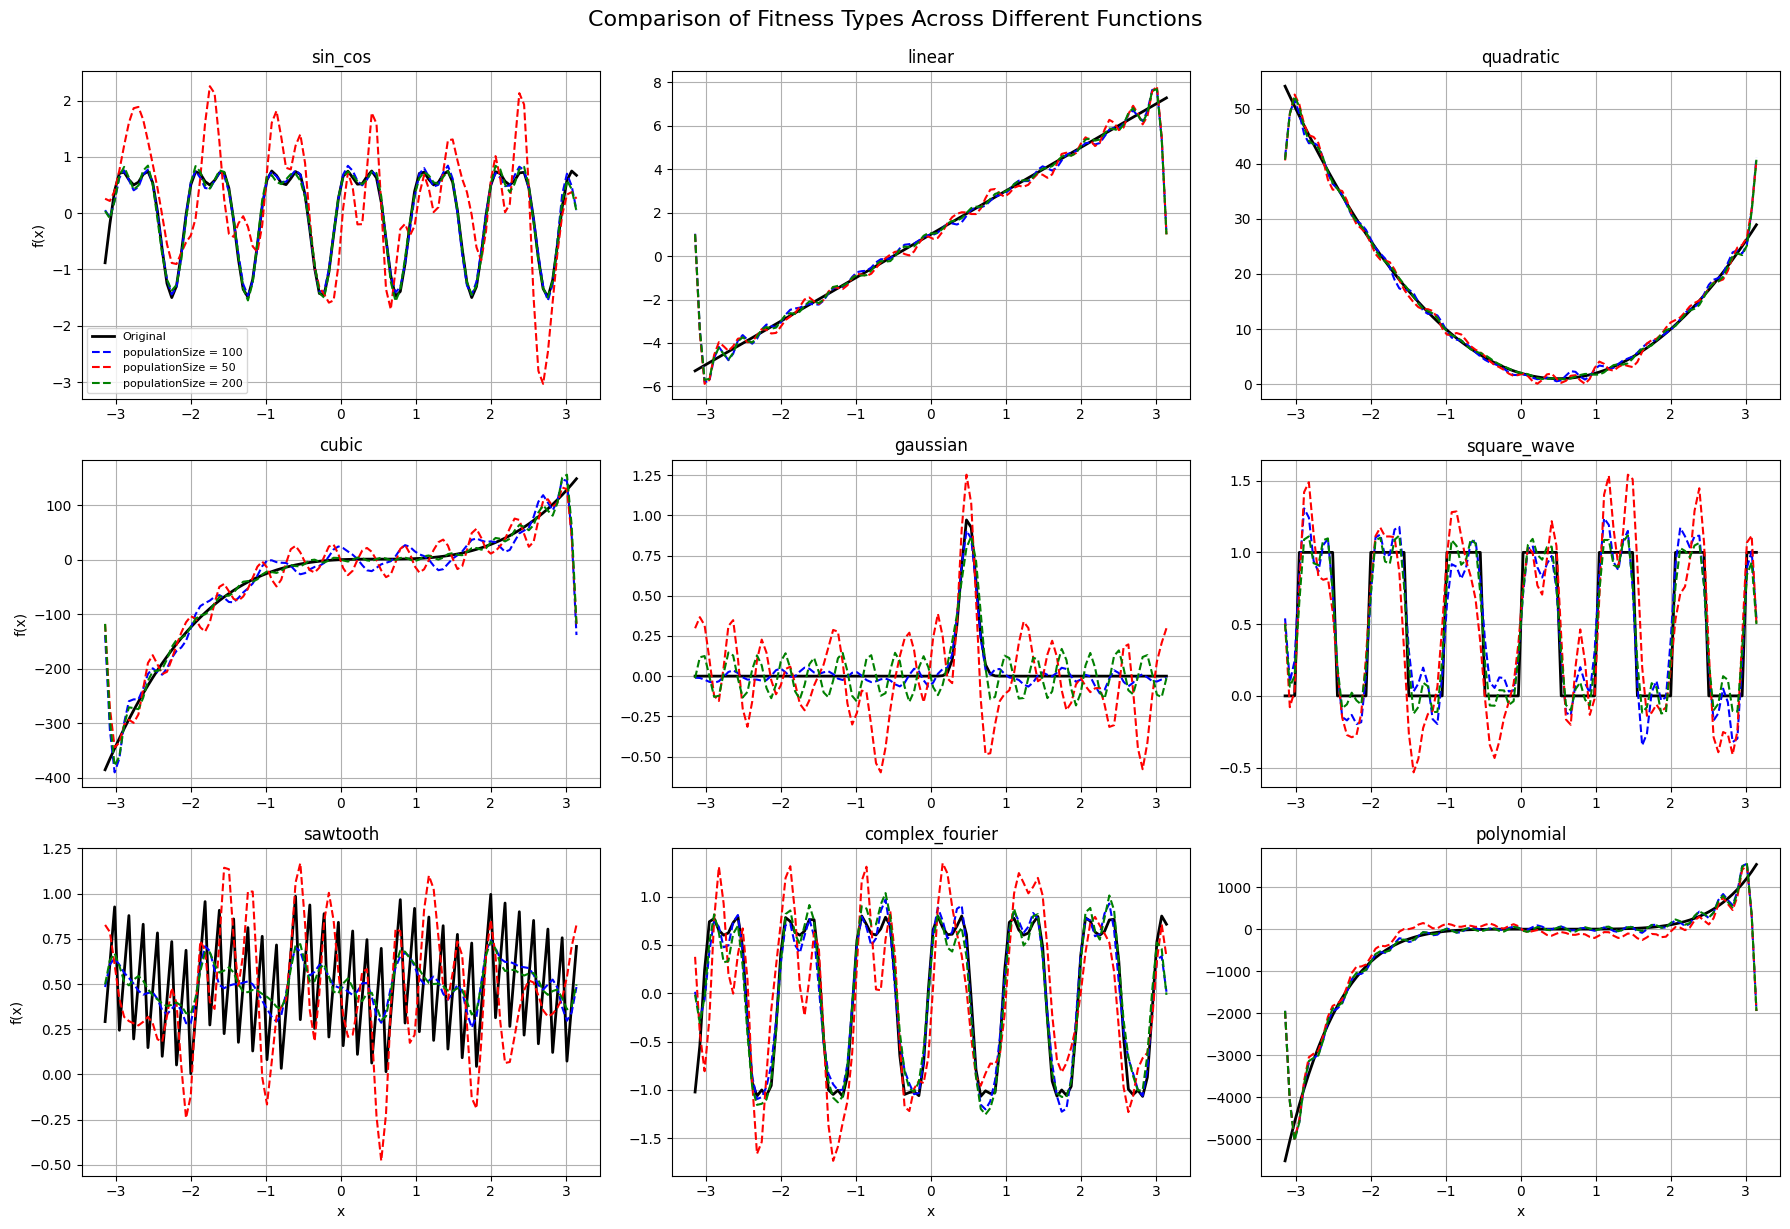

In [29]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    populationSize = 100
    f_vals = calc_final_f_vals(tSamples, fSamples)

    populationSize = 50
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    populationSize = 200
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='populationSize = 100', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='populationSize = 50', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='populationSize = 200', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Fitness Types Across Different Functions', fontsize=16, y=1.02)
plt.show()

Generations size

In [ ]:
function_name = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]
populationSize = 100
generations = 200
mutationRate = 0.01
coeff_range = (-2, 2)
crossover_rate =  0.8
fitness_type = 0 
crossover_type = 2
selection_type = 0

plt.figure(figsize=(18, 12))

for i, name in enumerate(function_name):
    tSamples, fSamples = gen_tsamples_and_fsamples(name)

    generations = 50
    f_vals = calc_final_f_vals(tSamples, fSamples)

    generations = 100
    f_vals2 = calc_final_f_vals(tSamples, fSamples)

    generations = 200
    f_vals3 = calc_final_f_vals(tSamples, fSamples)

    plt.subplot(3, 3, i + 1)
    plt.plot(tSamples, fSamples, label='Original', color='black', linewidth=2)
    plt.plot(tSamples, f_vals, label='generations = 50', linestyle='--', color='blue')
    plt.plot(tSamples, f_vals2, label='generations = 100', linestyle='--', color='red')
    plt.plot(tSamples, f_vals3, label='generations = 200', linestyle='--', color='green')
    
    plt.title(name)
    plt.grid(True)
    if i == 0:
        plt.legend(fontsize=8)
    if i >= 6:
        plt.xlabel('x')
    if i % 3 == 0:
        plt.ylabel('f(x)')

plt.tight_layout()
plt.suptitle('Comparison of Fitness Types Across Different Functions', fontsize=16, y=1.02)
plt.show()


## 🎮 Part 2: Implementing Pentago with Minimax Algorithm

**Objective:**  
Build a playable version of the Pentago board game and implement an AI opponent using the Minimax algorithm.

---

# <span style="color: #3498db;">Minmax Algorithm</span>

In [1]:
import random
import numpy as np
from math import inf
import time
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
weight_comp_heuristic = np.array([5,10,100, 1000])
weight_human_heuristic = np.array([-3,-8,-80,-800])
important_points = [[2, 2], [2, 3],[3, 2], [3, 3]]

In [3]:
class PentagoGame:
    def __init__(self, prunning, ui=False, print=False, depth=2):
        self.board = np.zeros((6, 6), dtype=int)
        self.current_player = 1
        self.ui = ui
        self.depth = depth
        self.nodes_visited = 0
        self.game_over = False
        self.result = None
        self.selected_block = None
        self.move_stage = 0  # 0: place piece, 1: select block, 2: rotate
        self.temp_piece = None
        self.print = print
        self.prunning = prunning
        self.total_time = 0
        self.total_nodes = 0
        if ui:
            pygame.font.init()
            self.screen = pygame.display.set_mode((800, 600))
            pygame.display.set_caption("Pygame Board")
            # self.font = pygame.font.SysFont("Arial", 20)
            self.show_buttons = False
            self.buttons = {
                "rotate_cw": pygame.Rect(650, 200, 100, 50),
                "rotate_ccw": pygame.Rect(650, 300, 100, 50),
            }
            self.setup_controls()
            self.draw_board()

    def setup_controls(self):
        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])   # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.screen.draw_text("CLOCKWISE", self.buttons["rotate_cw"].center)
            self.screen.draw_text("COUNTER-CLOCKWISE", self.buttons["rotate_ccw"].center)

    def hide_rotation_buttons(self):
        self.show_buttons = False

    def show_rotation_buttons(self):
        self.show_buttons = True

    def copy_board(self, board):
        return np.copy(board)

    def rotate_block(self, board, block, direction):
        row_start = (block // 2) * 3
        col_start = (block % 2) * 3
        sub = board[row_start : row_start + 3, col_start : col_start + 3]
        rotated = np.rot90(sub, 3 if direction == "cw" else 1)
        board[row_start : row_start + 3, col_start : col_start + 3] = rotated

    def get_possible_moves(self, board, player):
        moves = []
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    for block in range(4):
                        for dir in ["cw", "ccw"]:
                            moves.append((i, j, block, dir))
        return moves

    def apply_move(self, board, move, player):
        new_board = self.copy_board(board)
        row, col, block, direction = move
        if new_board[row][col] != 0:
            return None
        new_board[row][col] = player
        self.rotate_block(new_board, block, direction)
        return new_board

    def check_winner(self, board):
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue

                # Horizontal
                if j <= 1 and np.all(board[i, j : j + 5] == board[i][j]):
                    return board[i][j]

                # Vertical
                if i <= 1 and np.all(board[i : i + 5, j] == board[i][j]):
                    return board[i][j]

                # Diagonal
                if (
                    i <= 1
                    and j <= 1
                    and all(board[i + k][j + k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]

                # Anti-diagonal
                if (
                    i <= 1
                    and j >= 4
                    and all(board[i + k][j - k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]
        if np.all(board != 0):
            return 0
        return None
    
    def heuristic_for_arr(self, arr):
        cnt = [0,0,0]
        # cnt -1, 0, 1
        for elem in arr:
            cnt[elem + 1] += 1
        if cnt[2] > 0 and cnt[0] > 0:
            return 0
        if 2 <= cnt[0] <= 5:
            return weight_comp_heuristic[cnt[0] - 2]
        elif 2 <= cnt[2] <= 5:
            return weight_human_heuristic[cnt[2] - 2]
        return 0

    def heuristic(self, board):
        sum = 0
        for (i, j) in important_points:
                if board[i][j] == -1:
                    sum += 1
                elif board[i][j] == 1:
                    sum += -1
        for i in range(6):
            for j in range(2):
                horizontal = board[i, j:j+5]
                vertical = board[j:j+5, i]
                sum += self.heuristic_for_arr(horizontal)
                sum += self.heuristic_for_arr(vertical)

        for i in range(2):
            for j in range(2):
                diagonal = [board[i+k][j+k] for k in range(5)]
                anti_diagonal = [board[i+k][j+4-k] for k in range(5)]
                sum += self.heuristic_for_arr(diagonal)
                sum += self.heuristic_for_arr(anti_diagonal)
        return sum

    def max_value(self, board, depth,alpha, beta):
        self.nodes_visited += 1
        if depth == 0:
            return self.heuristic(board)
        max_val = -inf
        moves = self.get_possible_moves(board, -1)
        for move in moves:
            new_board = self.apply_move(board, move, -1)
            if new_board is None:
                continue
            val = self.min_value(new_board, depth-1, alpha, beta)
            max_val = max(val, max_val)
            alpha = max(alpha, val)
            if self.prunning:
                if alpha >= beta:
                    break
        return max_val

    def min_value(self, board, depth, alpha, beta):
        self.nodes_visited += 1
        if depth == 0:
            return self.heuristic(board)
        min_val = inf
        moves = self.get_possible_moves(board, 1)
        for move in moves:
            new_board = self.apply_move(board, move, 1)
            if new_board is None:
                continue
            val = self.max_value(new_board, depth-1, alpha, beta)
            min_val = min(min_val, val)
            beta = min(beta, val)
            if self.prunning:
                if alpha >= beta:
                    break
        return min_val

    def minimax(self, board, alpha, beta):
        return self.min_value(board, self.depth - 1, alpha, beta)

    def get_computer_move(self):
        start_time = time.time()
        best_move = None
        best_value = -inf
        
        moves = self.get_possible_moves(self.board, -1)
        if not moves:
            return None
        best_move = moves[0]
        alpha, beta = -inf, inf
        for move in moves:
            if self.game_over:
                break
            new_board = self.apply_move(self.board, move, -1)
            if new_board is None:
                continue

            try:
                value = self.minimax(new_board, alpha, beta)
                alpha = max(value, alpha)
            except:
                value = -inf

            if value > best_value:
                best_value = value
                best_move = move

        if self.print == True:
            self.total_nodes += self.nodes_visited
            self.total_time += time.time()-start_time
            print(f"Move took {time.time()-start_time:.2f}s, nodes visited: {self.nodes_visited}")
        self.nodes_visited = 0
        return best_move

    def draw_text(self, text, center_pos, max_width):
        font_size = 24
        font = pygame.font.Font(None, font_size)
        text_surface = font.render(text, True, (0, 0, 0))

        text_width = text_surface.get_width()
        if text_width > max_width:
            scale_factor = max_width / text_width
            new_font_size = int(font_size * scale_factor)
            font = pygame.font.Font(None, new_font_size)
            text_surface = font.render(text, True, (0, 0, 0))

        text_rect = text_surface.get_rect(center=center_pos)
        self.screen.blit(text_surface, text_rect)

    def draw_board(self):
        self.screen.fill((0, 0, 0))

        for i in range(6):
            for j in range(6):
                x0 = j * 100
                y0 = i * 100

                if self.board[i][j] == 1:
                    pygame.draw.circle(self.screen, (255, 0, 0), (x0 + 50, y0 + 50), 40)
                elif self.board[i][j] == -1:
                    pygame.draw.circle(self.screen, (0, 0, 255), (x0 + 50, y0 + 50), 40)

                pygame.draw.rect(self.screen, (255, 255, 255), (x0, y0, 100, 100), 1)

        for i in [3, 6]:
            pygame.draw.line(self.screen, (255, 255, 255), (0, i * 100), (600, i * 100), 3)  # Horizontal
            pygame.draw.line(self.screen, (255, 255, 255), (i * 100, 0), (i * 100, 600), 3)  # Vertical

        # Show rotation buttons if in move_stage 2
        if self.move_stage == 2:
            self.highlight_selected_block()
            self.show_rotation_buttons()

        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])  # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.draw_text(
                "CLOCKWISE",
                self.buttons["rotate_cw"].center,
                self.buttons["rotate_cw"].width,
            )
            self.draw_text(
                "COUNTER-CLOCKWISE",
                self.buttons["rotate_ccw"].center,
                self.buttons["rotate_ccw"].width,
            )

    def click_handler(self, event):
        if self.game_over or self.current_player != 1:
            return

        x, y = event.pos
        if self.move_stage == 0:  # Place piece
            if x > 600:
                return  # clicks on control area
            col = x // 100
            row = y // 100
            if 0 <= row < 6 and 0 <= col < 6 and self.board[row][col] == 0:
                self.temp_piece = (row, col)
                self.board[row][col] = 1
                self.move_stage = 1
                self.draw_board()

        elif self.move_stage == 1:  # Select block
            if x > 600:
                return
            # which block was clicked
            block_x = 0 if x < 300 else 1
            block_y = 0 if y < 300 else 1
            self.selected_block = block_y * 2 + block_x
            self.move_stage = 2
            self.show_rotation_buttons()
            self.highlight_selected_block()

        elif self.move_stage == 2:  # Rotate
            if self.buttons["rotate_cw"].collidepoint(event.pos):
                self.apply_rotation("cw")
            if self.buttons["rotate_ccw"].collidepoint(event.pos):
                self.apply_rotation("ccw")

    def apply_rotation(self, direction):
        self.rotate_block(self.board, self.selected_block, direction)
        self.current_player = -1
        self.move_stage = 0
        self.selected_block = None
        self.temp_piece = None
        self.hide_rotation_buttons()
        self.draw_board()
        pygame.display.flip()
        self.check_game_over()
        pygame.time.delay(1000)
        self.play_computer_move()

    def highlight_selected_block(self):
        colors = [
            (255, 153, 153),
            (153, 255, 153),
            (153, 153, 255),
            (255, 255, 153),
        ]  # RGB colors

        row_start = (self.selected_block // 2) * 3
        col_start = (self.selected_block % 2) * 3

        pygame.draw.rect(
            self.screen,
            colors[self.selected_block],
            (col_start * 100, row_start * 100, 300, 300),
            5,
        )

    def play_computer_move(self):
        move = self.get_computer_move()
        if move and not self.game_over:
            new_board = self.apply_move(self.board, move, -1)
            if new_board is not None:
                self.board = new_board
                self.current_player = 1
                self.draw_board()
                pygame.display.flip()
                self.check_game_over()
            else:
                print("Invalid computer move!")

    def check_game_over(self):
        winner = self.check_winner(self.board)
        if winner is not None:
            self.game_over = True
            self.result = winner
            print("Game over! Result:", winner)
            if self.ui:
                self.show_game_over_message()

    def show_game_over_message(self):
        self.screen.fill((200, 200, 200))
        pygame.draw.rect(self.screen, (255, 255, 255), (100, 200, 500, 200))
        pygame.draw.rect(self.screen, (0, 0, 0), (100, 200, 500, 200), 3)

        result_text = f"Player {self.result} wins!" if self.result != 0 else "Draw!"
        text_surface = self.font_large.render(result_text, True, (255, 0, 0))
        self.screen.blit(text_surface, (250, 250))

        exit_text = self.font_small.render("Click anywhere to exit", True, (0, 0, 0))
        self.screen.blit(exit_text, (230, 350))
        pygame.display.flip()

    def play(self):
        if self.ui:
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        self.click_handler(event)
                self.draw_board()
                pygame.display.flip()
            pygame.quit()
            return self.result
        else:
            while not self.game_over:
                self.print_board()
                winner = self.check_winner(self.board)
                if winner is not None:

                    return winner

                if self.current_player == 1:
                    move = random.choice(self.get_possible_moves(self.board, 1))
                else:
                    move = self.get_computer_move()

                self.board = self.apply_move(self.board, move, self.current_player)
                self.current_player *= -1
            return self.result

    def print_board(self):
        if self.print == False:
            return
        print("-" * 25)
        for row in self.board:
            print(" ".join(f"{x:2}" for x in row))
        print("-" * 25)
    def get_total_time(self):
        return self.total_time
    def get_total_nodes(self):
        return self.total_nodes

In [16]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
prunning = False
total_time = 0
total_nodes = 0
for i in range(numGames):
    game = PentagoGame(prunning, ui=False, print=True, depth=1)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    total_time += game.get_total_time()
    total_nodes += game.get_total_nodes()
    print(f"in game {i} out of {numGames} took {game.get_total_time()} seconds and {game.get_total_nodes()} nodes were visited")
print(f"{numWins} wins, {numTies} ties, {numLosses} losses, prunning {prunning}")

print(f"mean time is {total_time / numGames } seconds, mean visited nodes {total_nodes / numGames}, probility of success {numWins / numGames}")

-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  1  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 0.03s, nodes visited: 280
-------------------------
 0  0  0  0  0  0
 0  0  0  0  1  0
 0  0 -1  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  1  0
-1  0  0  0  0  0
 1  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 0.02s, nodes visited: 264
-------------------------
 0  0  0  0  0  0
 0  0  0  0  1  0
 0  0 -1 -1  0  0
 1  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  1  0
 0  0 -1 -1  1  0
 1  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0 

In [17]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
prunning = False
total_time = 0
total_nodes = 0
for i in range(numGames):
    game = PentagoGame(prunning, ui=False, print=True, depth=2)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    total_time += game.get_total_time()
    total_nodes += game.get_total_nodes()
    print(f"in game {i} out of {numGames} took {game.get_total_time()} seconds and {game.get_total_nodes()} nodes were visited")
print(f"{numWins} wins, {numTies} ties, {numLosses} losses, prunning {prunning}")

print(f"mean time is {total_time / numGames } seconds, mean visited nodes {total_nodes / numGames}, probility of success {numWins / numGames}")

-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  1  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 10.58s, nodes visited: 76440
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-1  0  0  0  0  0
 1  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-1  1  0  0  0  0
 1  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 7.85s, nodes visited: 67848
-------------------------
 0  0  0  0  0  0
 0 -1  0  0  0  0
 0  0  0  0  0  0
-1  1  0  0  0  0
 1  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0 -1  0  0  0  0
 0  0  0  0  0  0
-1  1  0  0  0  0
 1  0  0  0  0  0
 1  0  

In [ ]:
numGames = 3
numWins, numTies, numLosses = 0, 0, 0
prunning = False
total_time = 0
total_nodes = 0
for i in range(numGames):
    game = PentagoGame(prunning, ui=False, print=True, depth=3)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    total_time += game.get_total_time()
    total_nodes += game.get_total_nodes()
    print(f"in game {i} out of {numGames} took {game.get_total_time()} seconds and {game.get_total_nodes()} nodes were visited")
print(f"{numWins} wins, {numTies} ties, {numLosses} losses, prunning {prunning}")

print(f"mean time is {total_time / numGames } seconds, mean visited nodes {total_nodes / numGames}, probility of success {numWins / numGames}")

-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  1  0  0
-------------------------
Move took 2598.04s, nodes visited: 20182680
-------------------------
 0  0  0  0  0  0
 0  0  0  0 -1  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  1  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0 -1  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  1  0  0  0  0
 0  0  0  1  0  0
-------------------------


In [4]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
prunning = True
total_time = 0
total_nodes = 0
for i in range(numGames):
    game = PentagoGame(prunning, ui=False, print=True, depth=1)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    total_time += game.get_total_time()
    total_nodes += game.get_total_nodes()
    print(f"in game {i} out of {numGames} took {game.get_total_time()} seconds and {game.get_total_nodes()} nodes were visited")
print(f"{numWins} wins, {numTies} ties, {numLosses} losses, prunning {prunning}")

print(f"mean time is {total_time / numGames } seconds, mean visited nodes {total_nodes / numGames}, probility of success {numWins / numGames}")

-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 1  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 0.04s, nodes visited: 280
-------------------------
 1  0  0  0  0  0
 0  0  0  0  0  0
 0  0 -1  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 1  0  1  0  0  0
 0  0  0  0  0  0
 0  0 -1  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 0.02s, nodes visited: 264
-------------------------
 1  0  1  0  0  0
 0  0  0  0  0  0
 0  0 -1 -1  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 1  0  1  0  0  0
 0  0  0  0  0  0
 0  0 -1  0  0 -1
 0  0  0  0  0  0
 0  0  1  0  0  0
 0  0  0  0 

In [5]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
prunning = True
total_time = 0
total_nodes = 0
for i in range(numGames):
    game = PentagoGame(prunning, ui=False, print=True, depth=2)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    total_time += game.get_total_time()
    total_nodes += game.get_total_nodes()
    print(f"in game {i} out of {numGames} took {game.get_total_time()} seconds and {game.get_total_nodes()} nodes were visited")
print(f"{numWins} wins, {numTies} ties, {numLosses} losses, prunning {prunning}")

print(f"mean time is {total_time / numGames } seconds, mean visited nodes {total_nodes / numGames}, probility of success {numWins / numGames}")

-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  1  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 1.52s, nodes visited: 13699
-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 1  0  0 -1  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  1  0  0  0
 0  0  0  0  0  0
 1  0  0 -1  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 1.51s, nodes visited: 6845
-------------------------
 0  0  1  0  0  0
 0  0  0  0  0  0
 1  0  0 -1  0  0
 0  0 -1  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  1  0  0  0
 0  0  0  0  0  1
 1  0  0 -1  0  0
-1  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0 

In [ ]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
prunning = True
total_time = 0
total_nodes = 0
for i in range(numGames):
    game = PentagoGame(prunning, ui=False, print=True, depth=3)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    total_time += game.get_total_time()
    total_nodes += game.get_total_nodes()
    print(f"in game {i} out of {numGames} took {game.get_total_time()} seconds and {game.get_total_nodes()} nodes were visited")
print(f"{numWins} wins, {numTies} ties, {numLosses} losses, prunning {prunning}")

print(f"mean time is {total_time / numGames } seconds, mean visited nodes {total_nodes / numGames}, probility of success {numWins / numGames}")

-------------------------
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 1  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 23.80s, nodes visited: 172525
-------------------------
 0  0  1  0  0  0
 0  0  0  0 -1  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  1  0  0  0
 0  0  0  0 -1  0
 0  0  1  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
 0  0  0  0  0  0
-------------------------
Move took 77.65s, nodes visited: 541322
-------------------------
 0  0  0  0  0  0
 0  0  0  0 -1  0
 1  0  1  0  0  0
 0  0  0  0  0  0
 0 -1  0  0  0  0
 0  0  0  0  0  0
-------------------------
-------------------------
 0  0  0  0  0  0
 0  0  0  0 -1  1
 1  0  1  0  0  0
 0  0  0  0  0  0
 0 -1  0  0  0  0
 0  